In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
i=0
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
!pip install pydicom
!pip install Pillow
import fastai 
from fastai.medical.imaging import *
from pathlib import Path

In [15]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

In [16]:
items=get_dicom_files("/kaggle/input/siim-dicom-images")
train_rle=pd.read_csv("/kaggle/input/siim-acr-pneumothorax-segmentation/stage_2_train.csv")
train_rle.head()
train_rle['Condition']=train_rle['EncodedPixels'].apply(lambda x:"no pneumothorax" if x in ['-1',' -1'] else "pneumothorax")



In [17]:
train_rle.head(5)

,Unnamed: 0,ImageId,EncodedPixels,Condition
0,420,1.2.276.0.7230010.3.1.4.8323329.3678.1517875178.953520,194329 37 960 69 919 111 913 117 910 116 912 58 14 42 922 43 22 40 922 24 39 45 980 46 979 49 976 54 971 54 972 53 973 53 972 53 973 53 972 53 972 54 971 55 970 56 969 57 968 57 968 57 968 58 967 59 966 61 964 62 963 63 962 63 961 64 961 64 961 64 960 65 960 65 960 66 959 66 959 66 959 66 959 66 958 66 958 67 957 68 956 68 957 68 957 67 957 67 958 65 960 64 960 63 962 62 962 61 964 59 965 59 965 58 967 56 968 54 970 53 971 51 973 50 975 47 977 46 979 44 980 42 983 40 985 38 987 35 990 32 993 28 997 24 1001 21 1005 18 1008 14,pneumothorax
1,9772,1.2.276.0.7230010.3.1.4.8323329.4200.1517875181.692066,-1,no pneumothorax
2,1542,1.2.276.0.7230010.3.1.4.8323329.4862.1517875185.159443,344265 2 1020 7 1015 9 1012 12 1010 14 1008 15 1007 17 1004 19 1003 19 1003 20 1002 21 1000 22 1000 23 998 24 997 25 996 27 995 27 996 27 995 28 994 28 994 29 992 31 991 33 990 33 989 34 989 34 989 35 987 36 987 36 987 36 986 38 985 38 985 38 986 37 986 36 987 36 987 36 986 36 987 36 987 36 988 34 989 34 989 34 989 33 991 32 991 32 991 31 992 31 993 30 993 30 993 30 993 30 994 29 994 28 995 28 995 28 996 27 996 27 996 27 997 26 997 26 998 25 999 24 999 25 999 24 999 24 1000 23 1000 24 1000 23 1000 23 1001 23 1001 22 1001 23 1001 22 1001 23 1001 22 1001 23 1001 23 1000 23 1001 23 1001 23 10...,pneumothorax
3,7532,1.2.276.0.7230010.3.1.4.8323329.12313.1517875238.510667,-1,no pneumothorax
4,5542,1.2.276.0.7230010.3.1.4.8323329.14214.1517875250.261204,-1,no pneumothorax


In [18]:
 !rm -rf  /kaggle/working/*
#!mkdir  siim_png-images
#!ls /kaggle/working/siim_png-images

directory = ["siim_png-images/mask","siim_png-images/train"]
parent_dir = "/kaggle/working/"
os.mkdir("siim_png-images")
for i in directory:
    os.mkdir( os.path.join(parent_dir, i) ) 

    

In [19]:
import pydicom
from PIL import Image

In [139]:
def rle2mask(rle,width,height):
    mask=np.zeros(width*height)
    array=np.asarray([int(x) for x in rle.split(' ')]) 
    start=array[0::2]
    length=array[1::2]
    current_pos=0
    for index,starts in enumerate(start):
        current_pos=starts
        mask[current_pos:current_pos+length[index]]=255
    print(mask[1018:1018+6])
    mask=mask.reshape((width, height))
    return mask

In [21]:
def change_dcm_to_png(items):
    b=items
    pattern = r'^/kaggle/input/siim-dicom-images/siim-original/dicom-images-(test|train)/(.+)$'
    match=re.findall(pattern,b)
    #print(match)
    #print(b)
    return match

In [22]:
def get_mask(encode,width,height):
    if encode==[] or encode==['-1'] or encode==[' -1']:
        mask=np.zeros(width*height)
        mask=mask.reshape((width, height))
        return mask 
    mask=rle2mask(encode[0],width,height)
    if len(encode)>1:
        for e in encode[1:]:
            mask+=rle2mask(e,width,height)
   
    return mask.T

In [44]:
len(items)

12089

In [140]:
import cv2
import os
import pydicom
import re
from skimage.transform import resize
input_dir="/kaggle/input/siim-dicom-images"
output_dir=["/kaggle/working/siim_png-images/mask/","/kaggle/working/siim_png-images/train/"]
def save_train_file(items, train_rle, img_size):
    d=0
    for f in items[3:4]:
        d+=1
        ds=pydicom.read_file(f)
        img=ds.pixel_array
        a=change_dcm_to_png(str(f))
        c=a[0][1].split('/')[-1][:-4]
        encode=list(train_rle.loc[train_rle['ImageId']==c,'EncodedPixels'].values)
        print(encode)
        encode=get_mask(encode,img.shape[1],img.shape[0])
        #print(encode.shape)
        #print(img)
        #encode=resize(encode,(img_size,img_size))
        img=resize(img,(img_size,img_size))
        #print(encode)
        #print(encode.shape)
        #print(encode)
        final=encode #+img*255
        #print(final)
        cv2.imwrite(output_dir[1]+c+'.png',final)
        print(output_dir[1]+c+'.png')
        train_rle['address']=train_rle['ImageId'].apply(lambda x : output_dir[1]+c+'.png')
        if d>5:
            break;

save_train_file(items, train_rle, 224)

    


['270649 3 1018 5 1017 6 1015 8 1013 10 1011 11 1010 13 1009 14 1007 15 1007 16 1005 18 1004 18 1004 19 1002 21 999 23 999 24 998 25 996 26 996 27 994 27 994 28 992 31 991 31 990 33 986 36 984 38 983 39 982 41 980 42 980 43 980 42 980 43 979 43 979 43 980 42 980 43 980 42 981 41 981 41 982 40 983 39 983 39 983 40 969 53 962 60 961 61 961 62 961 61 961 62 961 62 962 60 964 59 964 59 965 59 966 57 967 56 968 55 969 55 969 54 971 52 972 52 973 50 974 49 975 49 975 48 975 49 975 48 975 49 974 49 975 49 974 49 973 51 968 56 959 64 957 67 956 67 959 65 961 62 964 60 967 56 973 51 977 47 979 44 983 40 986 38 988 35 991 32 995 28 998 24 1002 21 1005 19 1008 16 1010 14 1012 11 1015 9 1019 4']
[255. 255. 255. 255. 255. 255.]
/kaggle/working/siim_png-images/train/1.2.276.0.7230010.3.1.4.8323329.6307.1517875197.531851.png


In [106]:
encode[270649:270649+4]

NameError: name 'encode' is not defined

In [1]:
Image.open("/kaggle/working/siim_png-images/train/1.2.276.0.7230010.3.1.4.8323329.6307.1517875197.531851.png")

NameError: name 'Image' is not defined

In [60]:
train_rle.columns

Index(['Unnamed: 0', 'ImageId', 'EncodedPixels', 'Condition', 'address'], dtype='object')

In [75]:
items[3:4]

(#1) [Path('/kaggle/input/siim-dicom-images/siim-original/dicom-images-test/1.2.276.0.7230010.3.1.2.8323329.6307.1517875197.531850/1.2.276.0.7230010.3.1.3.8323329.6307.1517875197.531849/1.2.276.0.7230010.3.1.4.8323329.6307.1517875197.531851.dcm')]

In [65]:
pneumothorax=DataBlock(blocks=(ImageBlock,CategoryBlock),
                      get_x= lambda x : x[4],
                      splitter=RandomSplitter(seed=42),
                      get_y=lambda x:x[3],
                      batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)])
dls = pneumothorax.dataloaders(train_rle, num_workers=2)


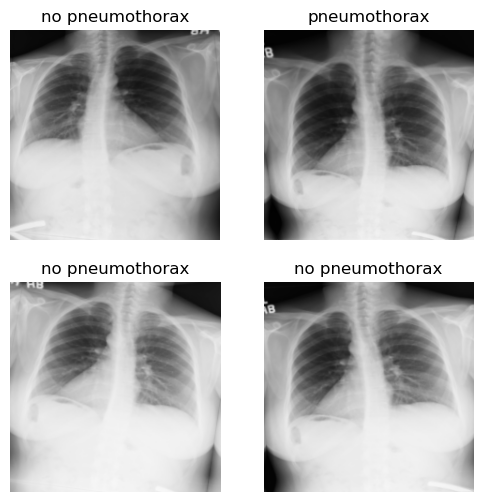

In [74]:
dls.show_batch(max_n=4)

In [28]:
learn=vision_learner(dls,resnet34,metrics=accuracy )

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 201MB/s] 


In [29]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [30]:
learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

SuggestedLRs(valley=0.0063095735386013985)

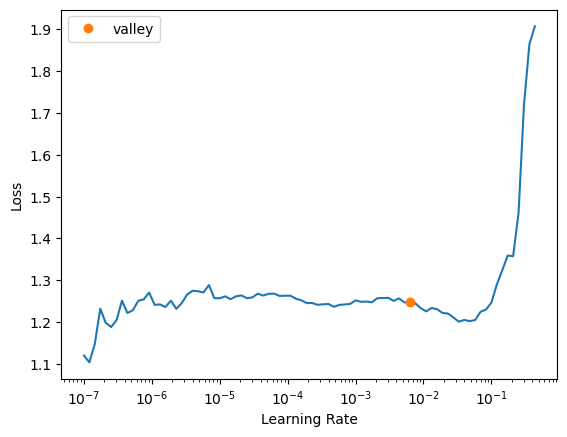

In [31]:
learn.lr_find()

In [32]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.978092,0.595621,0.733977,00:44
1,0.713807,0.580042,0.733977,00:44
2,0.652363,0.579708,0.733977,00:45
3,0.624986,0.579265,0.733977,00:44


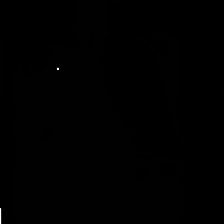

In [33]:
#Image.open("/kaggle/working/siim_png-images/train/1.2.276.0.7230010.3.1.4.8323329.6307.1517875197.531851.png")

#Image.open("/kaggle/working/siim_png-images/mask/1.2.276.0.7230010.3.1.4.8323329.6307.1517875197.531851.png")

#Image.open("/kaggle/working/siim_png-images/train/1.2.276.0.7230010.3.1.4.8323329.6307.1517875197.531851.png")
Image.open("/kaggle/working/siim_png-images/train/1.2.276.0.7230010.3.1.4.8323329.6307.1517875197.531851.png")

In [34]:
!ls /kaggle/working/siim_png-images/train | head -4

1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.png
1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.png
1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580.png
1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.png
ls: write error: Broken pipe


In [35]:
learn.predict("/kaggle/working/siim_png-images/train/1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.png")

('no pneumothorax', tensor(0), tensor([0.5916, 0.4084]))

In [36]:
tta=learn.tta(use_max=True)

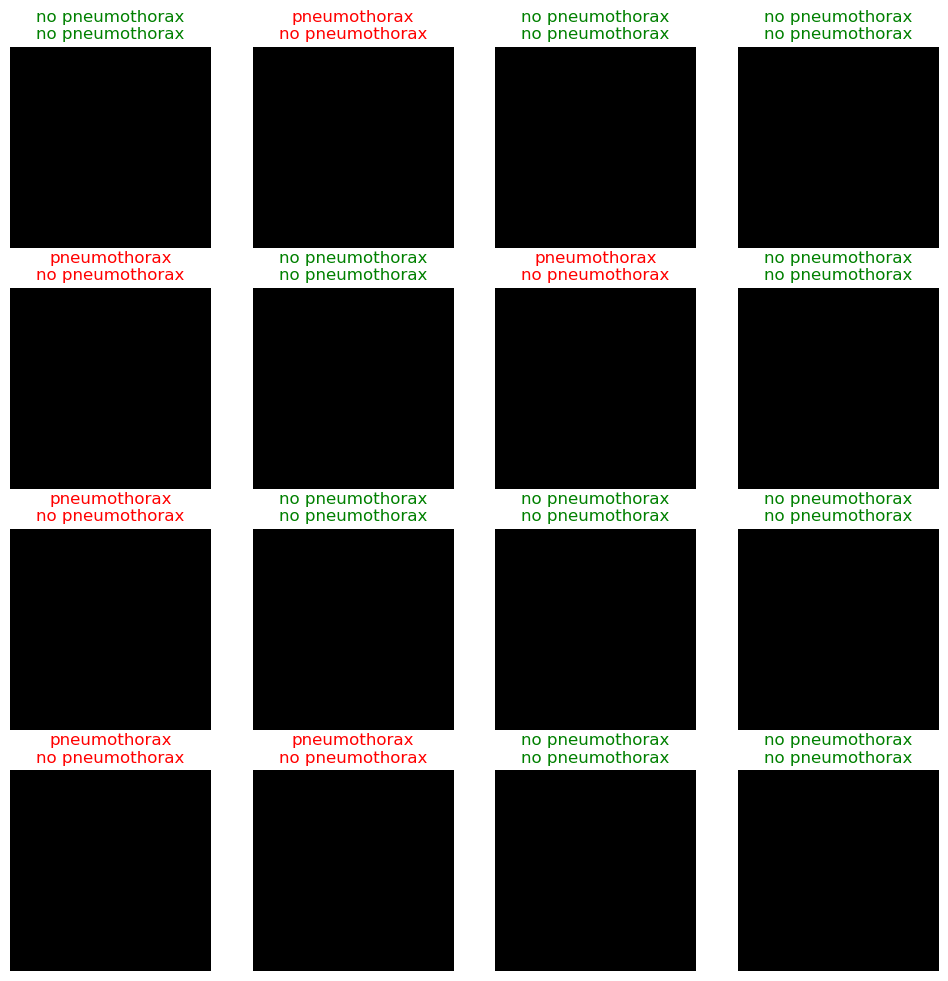

In [37]:
learn.show_results(max_n=16)

In [38]:
interp=Interpretation.from_learner(learn)

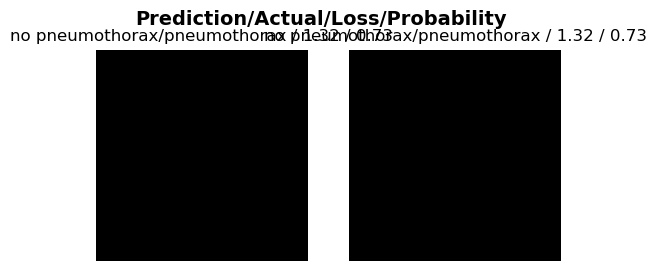

In [39]:
interp.plot_top_losses(2)

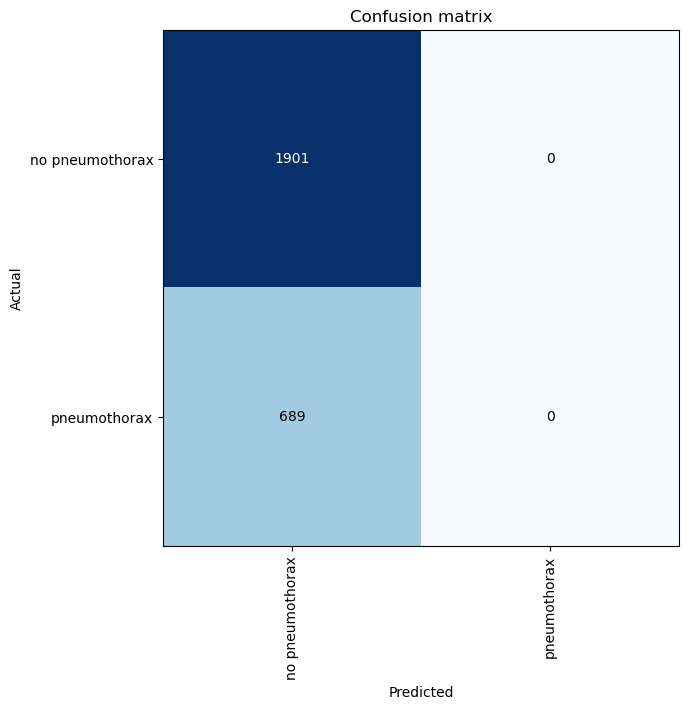

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))